# Transfer Learning

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls



adc.json  drive  sample_data


In [10]:
import os
os.chdir('presidential_doggy_door')

In [11]:
!ls

train  transferLearning.ipynb  valid


## Objectives
Prepare a pretrained model for transfer learning
Perform transfer learning with your own small dataset on a pretrained model
Further fine tune the model for even better performance

## A Personalized Doggy Door
In our last exercise, we used a pre-trained ImageNet model to let in all dogs, but keep out other animals. In this exercise, we would like to create a doggy door that only lets in a particular dog. In this case, we will make an automatic doggy door for a dog named Bo, the United States First Dog between 2009 and 2017. There are more pictures of Bo in the presidential_doggy_door folder.

## Downloading the Pretrained Model

In [12]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Freezing the Base Model

In [14]:
base_model.trainable = False

## Adding New Layers

In [15]:
inputs=keras.Input(shape=(224,224,3))

x=base_model(inputs, training=False)
x=keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## Compiling the Model

In [18]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=[keras.metrics.BinaryAccuracy()])

## Augmenting the Data

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

## Loading the Data

In [22]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('valid/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 139 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [23]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 69s 6s/step - loss: 4.4527 - binary_accuracy: 0.4066 - val_loss: 2.2522 - val_binary_accuracy: 0.5333
Epoch 2/20
12/12 [==============================] - 17s 1s/step - loss: 0.7936 - binary_accuracy: 0.7692 - val_loss: 1.8243 - val_binary_accuracy: 0.6000
Epoch 3/20
12/12 [==============================] - 7s 580ms/step - loss: 0.6071 - binary_accuracy: 0.8125 - val_loss: 1.8125 - val_binary_accuracy: 0.7000
Epoch 4/20
12/12 [==============================] - 4s 308ms/step - loss: 0.4002 - binary_accuracy: 0.8462 - val_loss: 1.3194 - val_binary_accuracy: 0.7333
Epoch 5/20
12/12 [==============================] - 4s 305ms/step - loss: 0.3233 - binary_accuracy: 0.8462 - val_loss: 0.7015 - val_binary_accuracy: 0.8000
Epoch 6/20
12/12 [==============================] - 2s 200ms/step - loss: 0.1962 - binary_accuracy: 0.9341 - val_loss: 0.6831 - val_binary_accuracy: 0.8333
Epoch 7/20
12/12 [==============================] - 2s 202ms/step - 

## Fine-Tuning the Model

In [24]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])


In [25]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 3s 272ms/step - loss: 0.0538 - binary_accuracy: 0.9780 - val_loss: 0.0145 - val_binary_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 3s 240ms/step - loss: 0.0091 - binary_accuracy: 1.0000 - val_loss: 0.1081 - val_binary_accuracy: 0.9667
Epoch 3/10
12/12 [==============================] - 3s 228ms/step - loss: 2.5882e-04 - binary_accuracy: 1.0000 - val_loss: 0.1546 - val_binary_accuracy: 0.9333
Epoch 4/10
12/12 [==============================] - 3s 237ms/step - loss: 5.8099e-05 - binary_accuracy: 1.0000 - val_loss: 0.0922 - val_binary_accuracy: 0.9667
Epoch 5/10
12/12 [==============================] - 3s 217ms/step - loss: 2.2947e-04 - binary_accuracy: 1.0000 - val_loss: 0.0152 - val_binary_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 3s 230ms/step - loss: 1.9820e-04 - binary_accuracy: 1.0000 - val_loss: 0.0704 - val_binary_accuracy: 0.9667
Epoch 7/10
12/12 [==============================

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

array([[-17.05729]], dtype=float32)

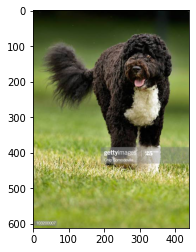

In [28]:
make_predictions('valid/bo/bo_20.jpg')

array([[30.377716]], dtype=float32)

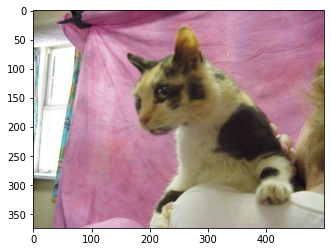

In [29]:
make_predictions('valid/not_bo/121.jpg')

## **It looks like a negative number prediction means that it is Bo and a positive number prediction means it is something else. We can use this information to have our doggy door only let Bo in!**

In [30]:
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

That's not Bo! Stay out!


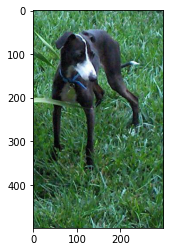

In [33]:
presidential_doggy_door('valid/not_bo/131.jpg')

It's Bo! Let him in!


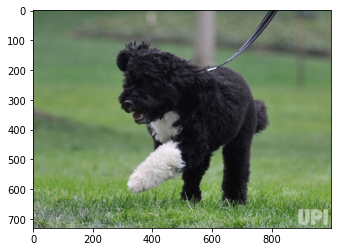

In [34]:
presidential_doggy_door('valid/bo/bo_29.jpg')

In [35]:
# https://developer.nvidia.com/tlt-getting-started you can use this toolkit:):)):)